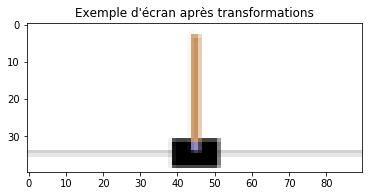

Episode 200/200. Longueur:170

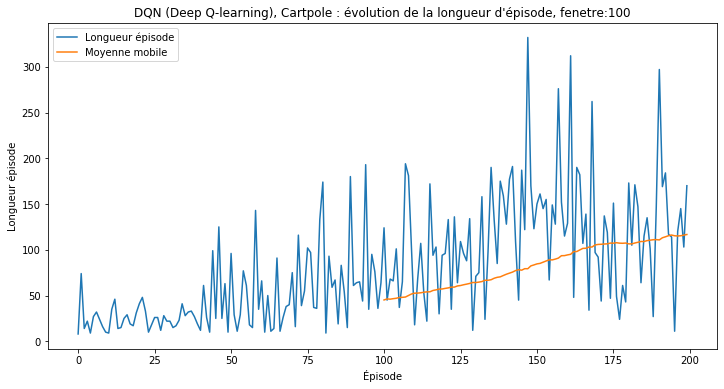

In [3]:
# -*- coding: utf-8 -*-
"""
Deep Q-learning avec cibles-Q fixes

"""
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

random.seed(42)
env = gym.make('CartPole-v0').unwrapped

Observation = namedtuple('Observation',
                        ('etat', 'action', 'etat_suivant', 'recompense'))
class HistoriqueObservations(object):
    """ Stockage de la liste des observations pour l'apprentissage 
        Mémoire circulaire pour limiter à taille_memoire"""
    def __init__(self, taille_memoire):
        self.taille_memoire = taille_memoire
        self.indice_courant = 0
        self.liste_observations = []


    def ajouter_historique(self, *args):
        """AJoutee une observation. Écriture circulaire."""
        if len(self.liste_observations) < self.taille_memoire:
            self.liste_observations.append(None)
        self.liste_observations[self.indice_courant] = Observation(*args)
        self.indice_courant = (self.indice_courant + 1) % self.taille_memoire

    def mini_lot_observations(self, taille_mini_lot):
        return random.sample(self.liste_observations, taille_mini_lot)

    def __len__(self):
        return len(self.liste_observations)
    
class RNAQ(nn.Module):
    """Prend un état en entrée et produit la prédiction de Q pour chacune des actions
    l'état est une représentation de l'écran (carré centré sur le chariot, différence entre deux images)
    3 canaux en entrée
    hauteur : hauteur de l'image en entrée
    largeur : largeur de limage
    nb_actions_y : le nombre d'actions possibles pour l'environnement
    
    """
    def __init__(self, hauteur, largeur, nb_actions_y):
        super(RNAQ, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2) # 3 canaux en entrée
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def taille_sortie_convolution(taille_h_ou_l, kernel_size = 5, stride = 2):
            """ Calculer la taille de la sortie en fonction des paramètres de la convolution
                taille_h_ou_l: taille de l'entrée (largeur ou hauteur de l'image)
            """
            return (taille_h_ou_l - (kernel_size - 1) - 1) // stride  + 1
        
        largeur_conv = taille_sortie_convolution(taille_sortie_convolution(taille_sortie_convolution(largeur)))
        hauteur_conv = taille_sortie_convolution(taille_sortie_convolution(taille_sortie_convolution(hauteur)))
        taille_X_lineaire = largeur_conv * hauteur_conv * 32
        self.couche_finale = nn.Linear(taille_X_lineaire, nb_actions_y)

    def forward(self, x):
        """ Retourne un mini-lot de vecteurs des probabilités pour les deux actions (gauche et droite)"""
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.couche_finale(x.view(x.size(0), -1))

def calculer_position_chariot(largeur_ecran):
    largeur_monde = env.x_threshold * 2
    echelle = largeur_ecran / largeur_monde
    return int(env.state[0] * echelle + largeur_ecran / 2.0)  # Milieu du chariot

transformer_image_ecran = T.Compose([T.ToPILImage(),T.Resize(40, interpolation=Image.CUBIC),T.ToTensor()])
def chercher_ecran():
    # Transposer l'image selon l'ordre (canal, largeur, hauteur)
    ecran = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Couper le haut et le bas de l'écran
    _, hauteur_ecran, largeur_ecran = ecran.shape
    ecran = ecran[:, int(hauteur_ecran*0.4):int(hauteur_ecran * 0.8)]
    largeur_vue = int(largeur_ecran * 0.6)
    position_chariot = calculer_position_chariot(largeur_ecran)
    if position_chariot < largeur_vue // 2:
        portee_tranche = slice(largeur_vue)
    elif position_chariot > (largeur_ecran - largeur_vue // 2):
        portee_tranche = slice(-largeur_vue, None)
    else:
        portee_tranche = slice(position_chariot - largeur_vue // 2,
                            position_chariot + largeur_vue // 2)
    # Découper les marges pour obtenir un carré centré sur le chariot
    ecran = ecran[:, :, portee_tranche]
    ecran = np.ascontiguousarray(ecran, dtype=np.float32) / 255
    ecran = torch.from_numpy(ecran)
    # transformer_image_ecran, et ajouter dimension pour mini_lot (mini_lot,canal,largeur,hauteur)
    return transformer_image_ecran(ecran).unsqueeze(0)

env.reset()
plt.figure()
plt.imshow(chercher_ecran().cpu().squeeze(0).permute(1, 2, 0).numpy(),interpolation='none')
plt.title("Exemple d'écran après transformations")
plt.show()

# Chercher taille de l'écran pour le RNA
ecran_initial = chercher_ecran() 
_, _, hauteur_ecran, largeur_ecran = ecran_initial.shape

# Initaliser le RNAQ
n_actions = env.action_space.n
rnaq = RNAQ(hauteur_ecran, largeur_ecran, n_actions)
optimiseur = optim.RMSprop(rnaq.parameters())
liste_observations = HistoriqueObservations(10000)

nombre_etapes_accomplies = 0

def choisir_action(etat,epsilon):
    """ Choisir l'action max Q (politique e-vorace) à partir de rnaq"""
    unif_01 = random.uniform(0, 1)
    if unif_01 > epsilon:
        with torch.no_grad():
            return rnaq(etat).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]],dtype=torch.long)

durees_par_episode = []

def afficher_longueur_episode(longueur_episode, fenetre=10):
    """
    Afficher l'évolution des longueurs d'épisodes avec le temps
    """
    plt.figure(figsize=(12,6))
    plt.plot(longueur_episode,label="Longueur épisode")
    longueur_moyenne_fenetre=[longueur_episode[i:i+fenetre].mean() for i in range(longueur_episode.shape[0]-fenetre)]
    plt.plot(np.arange(fenetre,longueur_episode.shape[0]),longueur_moyenne_fenetre,label="Moyenne mobile")
    plt.xlabel("Épisode")
    plt.ylabel("Longueur épisode")
    plt.title("DQN (Deep Q-learning), Cartpole : évolution de la longueur d'épisode, fenetre:"+str(fenetre))
    plt.legend(loc='upper left')
    plt.show()

def optimisation_RNAQ(taille_mini_lot = 128, gamma=1.0):
    if len(liste_observations) < taille_mini_lot:
        return
    observations = liste_observations.mini_lot_observations(taille_mini_lot)
    # Transposer le mini_lot
    mini_lot = Observation(*zip(*observations))

    # masque_non_final[i] est True si etat[i] n'est pas final
    masque_non_final = torch.tensor(tuple(map(lambda s: s is not None,
                                          mini_lot.etat_suivant)),dtype=torch.bool)
    non_final_etat_suivants = torch.cat([s for s in mini_lot.etat_suivant if s is not None])
    mini_lot_etats = torch.cat(mini_lot.etat)
    mini_lot_actions = torch.cat(mini_lot.action)
    mini_lot_recompenses = torch.cat(mini_lot.recompense)

    # Chercher la valeur de Q(s,a) pour l'action a qui a été choisie selon l'historique
    mini_lot_Q = rnaq(mini_lot_etats).gather(1, mini_lot_actions)

    # Calculer la valeur cible (R+maxQ) selon la politique cible (Q est 0 si état final)
    mini_lot_Q_suivant = torch.zeros(taille_mini_lot)
    mini_lot_Q_suivant[masque_non_final] = rnaq(non_final_etat_suivants).max(1)[0].detach()
    mini_lot_Q_cibles = (mini_lot_Q_suivant * gamma) + mini_lot_recompenses

    # Calculer l'erreur Huber
    #cout = F.smooth_l1_loss(mini_lot_Q, mini_lot_Q_cibles.unsqueeze(1))
    cout = F.mse_loss(mini_lot_Q, mini_lot_Q_cibles.unsqueeze(1))

    # Retropropagation
    optimiseur.zero_grad()
    cout.backward()
    for parametre in rnaq.parameters(): # Limiter les gradients (clip) pour stabiliser l'optimisation
        parametre.grad.data.clamp_(-1, 1)
    optimiseur.step()
    
def optimiser_DQN(env, nombre_episodes=20,  gamma=1.0, alpha=0.1, epsilon_max=1, epsilon_min=0.05,
                  epsilon_taux_decroissance = 0.005, frequence_maj_rnaq_cible=10):    
    longueur_episode = np.zeros(nombre_episodes)
    for i_episode in range(nombre_episodes):
        env.reset() # Initialiser l'environnement et l'état
        ecran_precedent = chercher_ecran()
        ecran_actuel = chercher_ecran()
        etat = ecran_actuel - ecran_precedent # Différence entre deux images d'écran consécutives
        # Calculer epsilon
        epsilon = epsilon_min + (epsilon_max - epsilon_min)*np.exp(-epsilon_taux_decroissance*i_episode) 

        compteur_action = 0
 
        for t in count():
            compteur_action +=1
            action = choisir_action(etat,epsilon) # Sélectionner et exécuter l'action
            _, recompense, fin_episode, _ = env.step(action.item())
            recompense = torch.tensor([recompense])
            # Produire l'état suivant
            ecran_precedent = ecran_actuel
            ecran_actuel = chercher_ecran()
            if not fin_episode:
                etat_suivant = ecran_actuel - ecran_precedent
            else:
                etat_suivant = None
            # Ajouter l'observation à l'historique
            liste_observations.ajouter_historique(etat, action, etat_suivant, recompense)
            etat = etat_suivant
            
            optimisation_RNAQ() # Optimiser le RNAQ avec un mini-lot
            if fin_episode:
                longueur_episode[i_episode] = t
                break
            
        print("\rEpisode {}/{}. Longueur:{}".format(i_episode+1, nombre_episodes, t), end="")
        sys.stdout.flush()

    return longueur_episode

longueur_episode = optimiser_DQN(env, nombre_episodes=200,gamma=0.999,alpha=0.1,epsilon_max=1,epsilon_min=0.05,
                  epsilon_taux_decroissance = 0.01,frequence_maj_rnaq_cible=10)

env.close()

afficher_longueur_episode(longueur_episode,fenetre=100)